## UCI-HAR 데이터셋 개요
- 데이터셋명: UCI-HAR (Human Activity Recognition Using Smartphones)
- 목적: 허리에 착용한 스마트폰의 센서 데이터를 사용해 6가지 인간 활동을 인식
- 피험자: 19세에서 48세 사이의 30명.
- 센서: 스마트폰(Samsung Galaxy S II)에 내장된 가속도계(Accelerometer)와 자이로스코프(Gyroscope).

- 활동 (총 6개):
1. WALKING
2. WALKING_UPSTAIRS
3. WALKING_DOWNSTAIRS
4. SITTING
5. STANDING
6. LAYING

- 데이터 특징:
    - 원시 센서 데이터(가속도, 각속도)는 2.56초의 고정된 창(window)으로 나뉘어 있다. 
    - 각 창에서 시간 및 주파수 영역의 561개 피처(feature)가 이미 추출되어 X_train.txt와 X_test.txt에 저장. (PAMAP2와 달리 원시 데이터를 직접 다루기보다, 이미 추출된 피처를 사용하는 경우가 일반적)
    - 데이터는 이미 70%의 훈련(Train) 데이터와 30%의 테스트(Test) 데이터로 split


- Input Format - DL
    - (N, C, T)
    - X.shape = (N, 9, 128)
    - y.shape = (N,)

- Significance
    - 다양한 딥러닝 구조의 성능 비교에 적합
    - 데이터 크기 적절
    - Label이 명확하여 HAR 연구의 표준 실험 환경으로 사용

- Reference
Anguita, D., Ghio, A., Oneto, L., Parra, X., & Reyes-Ortiz, J. L. (2013). A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21st European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning (ESANN 2013).
https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from scipy.fft import fft
from scipy.fft import fftfreq
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

In [5]:
class UCIHARDataset(Dataset):
    def __init__(self, data_path, split='train'):
        base = Path(data_path) / split
 
        signals = []
        for sensor in ['body_acc', 'body_gyro', 'total_acc']:
            for axis in ['x', 'y', 'z']:
                file = base / 'Inertial Signals' / f'{sensor}_{axis}_{split}.txt'
                signals.append(np.loadtxt(file))

        self.X = np.stack(signals, axis=-1)
        self.y = np.loadtxt(base.parent / split / f'y_{split}.txt').astype(int) - 1

        try:
           self.subjects = np.loadtxt(base.parent / split / f'subject_{split}.txt').astype(int)
        except:
            self.subjects = np.ones(len(self.y))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (torch.FloatTensor(self.X[idx]),
                torch.LongTensor([self.y[idx]])[0],
                self.subjects[idx])

data_path = "C://Users/park9/HAR-EDA/data"
train_ds = UCIHARDataset(data_path, split='train')
test_ds = UCIHARDataset(data_path, split='test')

print(f"Train: {len(train_ds)} samples, Test: {len(test_ds)} samples\n")

Train: 7352 samples, Test: 2947 samples



In [6]:
# 1. Train/Test의 y(레이블)와 subjects(피험자)를 Rnumpy 배열로 결합
all_y = np.concatenate([train_ds.y, test_ds.y])
all_subjects = np.concatenate([train_ds.subjects, test_ds.subjects])

# 2. 레이블 맵 (사용자님의 코드에서 y를 0부터 시작하도록 -1 했으므로 0-5)
# UCI-HAR의 activity_labels.txt 순서 기준
activity_mapping = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING'
}

# 3. 시각화를 위한 Pandas DataFrame 생성
df = pd.DataFrame({
    'subject_id': all_subjects,
    'activity_id': all_y
})
df['activity_name'] = df['activity_id'].map(activity_mapping)

print("EDA용 통합 DataFrame:")
display(df.head())
print(f"전체 데이터 수: {len(df)}")

EDA용 통합 DataFrame:


,subject_id,activity_id,activity_name
0,1.0,4,STANDING
1,1.0,4,STANDING
2,1.0,4,STANDING
3,1.0,4,STANDING
4,1.0,4,STANDING


전체 데이터 수: 10299


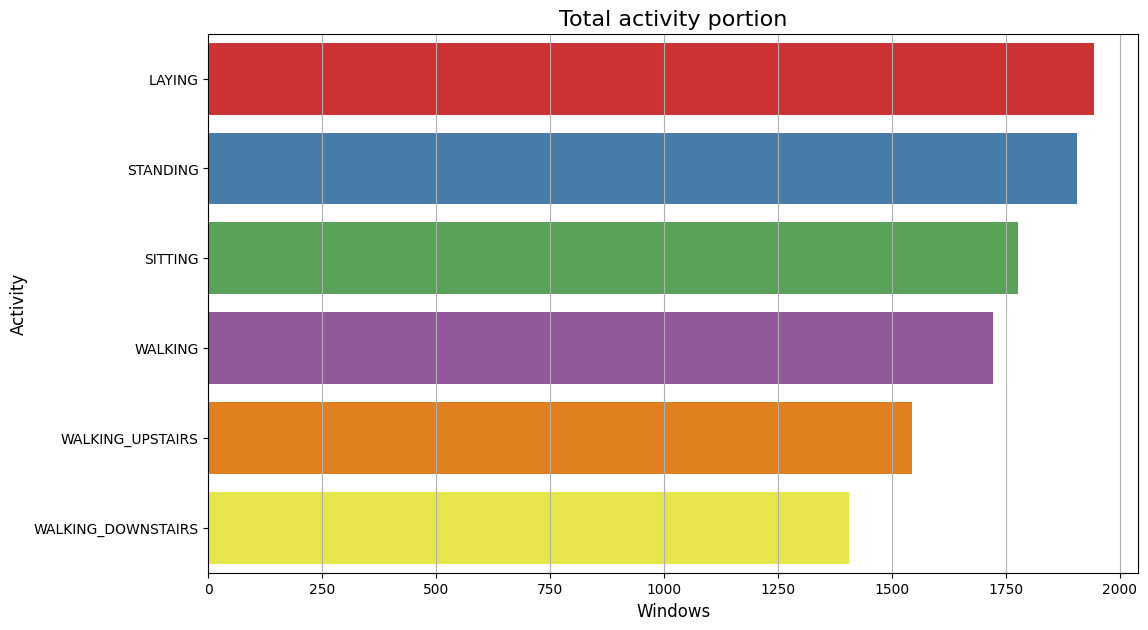

In [7]:
plt.figure(figsize=(12, 7))
sns.countplot(
    y='activity_name', 
    data=df, 
    order=df['activity_name'].value_counts().index,
    palette="Set1"
)
plt.title('Total activity portion', fontsize=16)
plt.xlabel('Windows', fontsize=12)
plt.ylabel('Activity', fontsize=12)
plt.grid(axis='x')
plt.show()

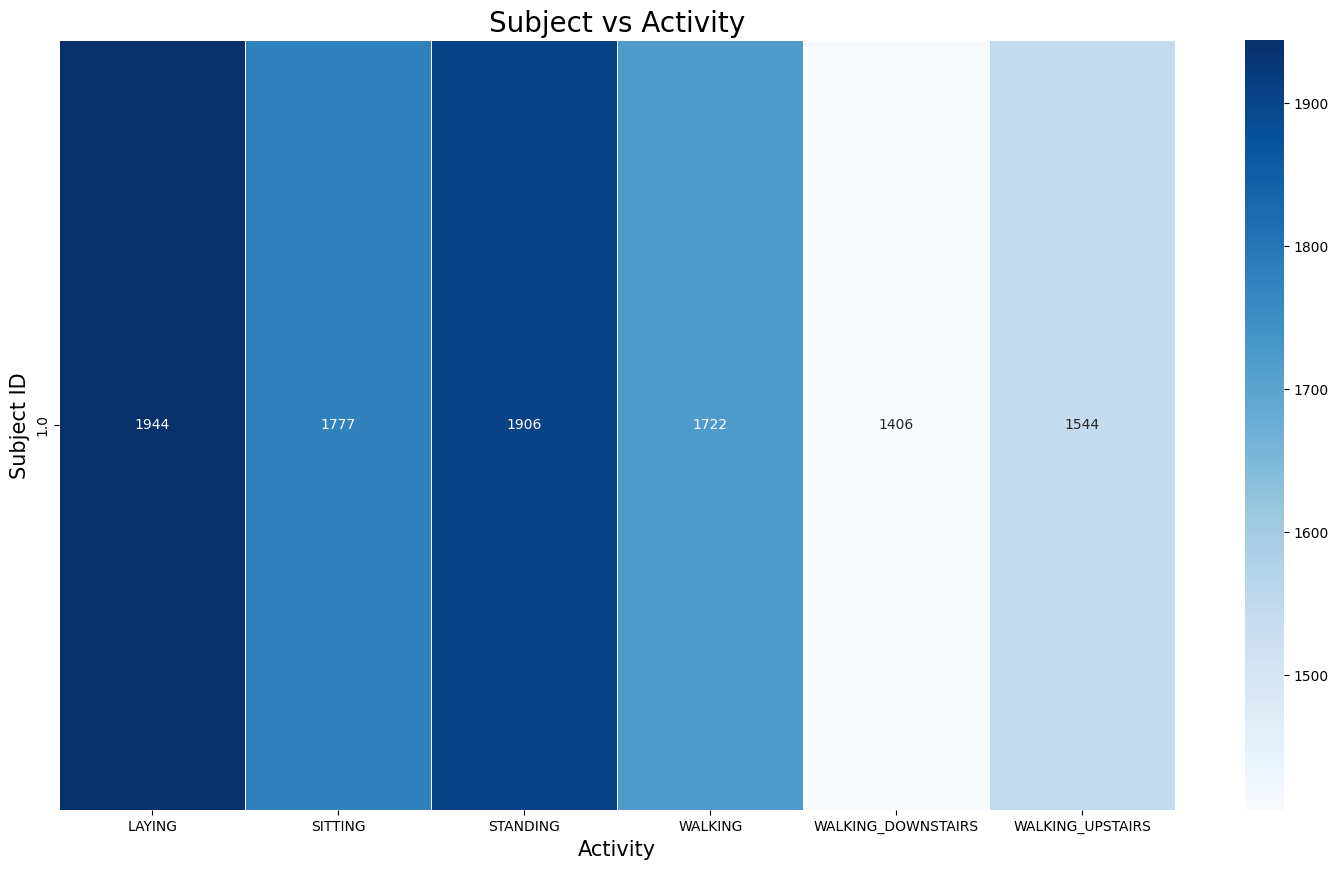

In [8]:
# 피험자 ID와 활동명을 기준으로 데이터 수 집계
subject_activity_matrix = df.groupby(['subject_id', 'activity_name']).size().unstack(fill_value=0)

plt.figure(figsize=(18, 10))
sns.heatmap(
    subject_activity_matrix, 
    annot=True,
    fmt='d',
    cmap='Blues',
    linewidths=.5
)
plt.title('Subject vs Activity', fontsize=20)
plt.xlabel('Activity', fontsize=15)
plt.ylabel('Subject ID', fontsize=15)
plt.show()

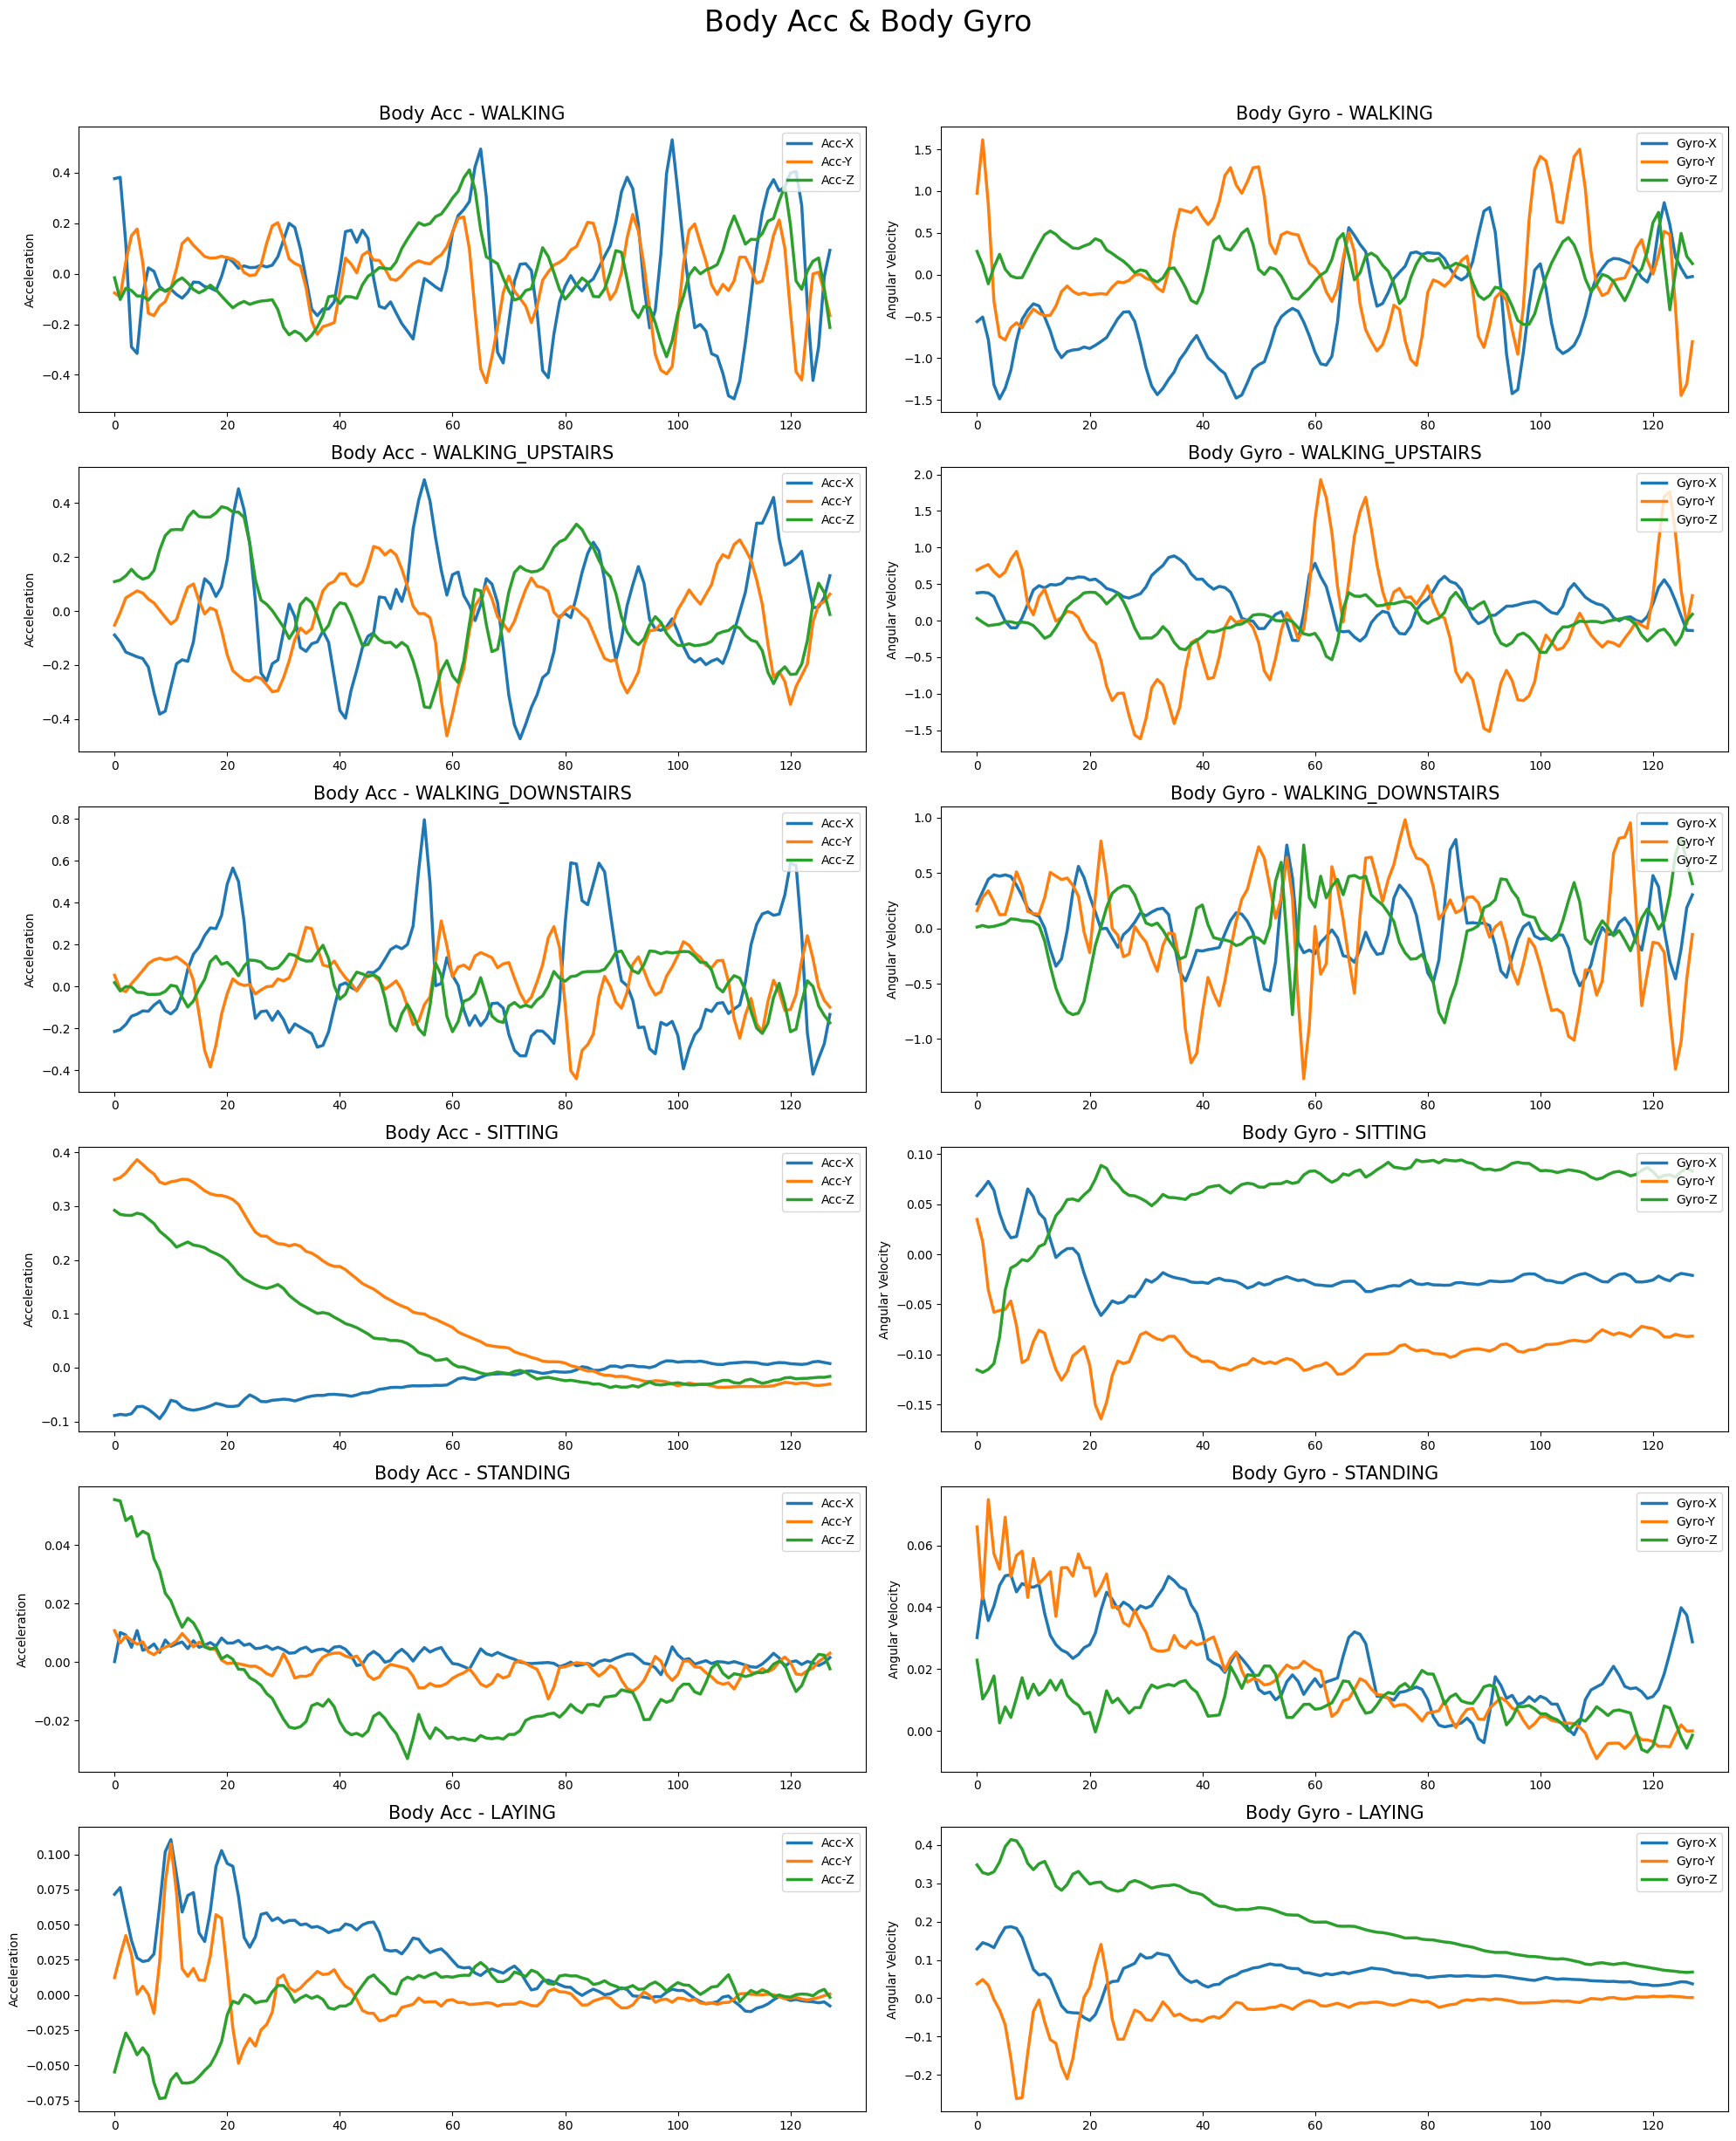

In [10]:
# 128개 타임스텝
time_steps = np.arange(128)

# 6개 활동 (0~5)
activity_names = list(activity_mapping.values())

# 각 활동의 첫 번째 샘플 인덱스를 찾기
activity_indices = {}
for activity_id in range(6):
    # train_ds.y에서 해당 활동 ID를 가진 첫 번째 데이터의 인덱스를 찾음
    first_index = np.where(train_ds.y == activity_id)[0][0]
    activity_indices[activity_names[activity_id]] = first_index

# --- Plot 생성 ---
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(20, 24))
fig.suptitle('Body Acc & Body Gyro', fontsize=24, y=1.02)

for i, activity_name in enumerate(activity_names):
    # 해당 활동의 첫 번째 샘플 인덱스
    sample_idx = activity_indices[activity_name]
    
    # 1. Body Accelerometer 플롯 (왼쪽 열) - 채널 0, 1, 2
    ax_acc = axes[i][0]
    ax_acc.plot(time_steps, train_ds.X[sample_idx, :, 0], label='Acc-X', linewidth=2.5)
    ax_acc.plot(time_steps, train_ds.X[sample_idx, :, 1], label='Acc-Y', linewidth=2.5)
    ax_acc.plot(time_steps, train_ds.X[sample_idx, :, 2], label='Acc-Z', linewidth=2.5)
    ax_acc.set_title(f'Body Acc - {activity_name}', fontsize=15)
    ax_acc.set_ylabel('Acceleration')
    ax_acc.legend(loc='upper right')
    
    # 2. Body Gyroscope 플롯 (오른쪽 열) - 채널 3, 4, 5
    ax_gyro = axes[i][1]
    ax_gyro.plot(time_steps, train_ds.X[sample_idx, :, 3], label='Gyro-X', linewidth=2.5)
    ax_gyro.plot(time_steps, train_ds.X[sample_idx, :, 4], label='Gyro-Y', linewidth=2.5)
    ax_gyro.plot(time_steps, train_ds.X[sample_idx, :, 5], label='Gyro-Z', linewidth=2.5)
    ax_gyro.set_title(f'Body Gyro - {activity_name}', fontsize=15)
    ax_gyro.set_ylabel('Angular Velocity')
    ax_gyro.legend(loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 1]) # suptitle과 겹치지 않도록 조정
plt.show()

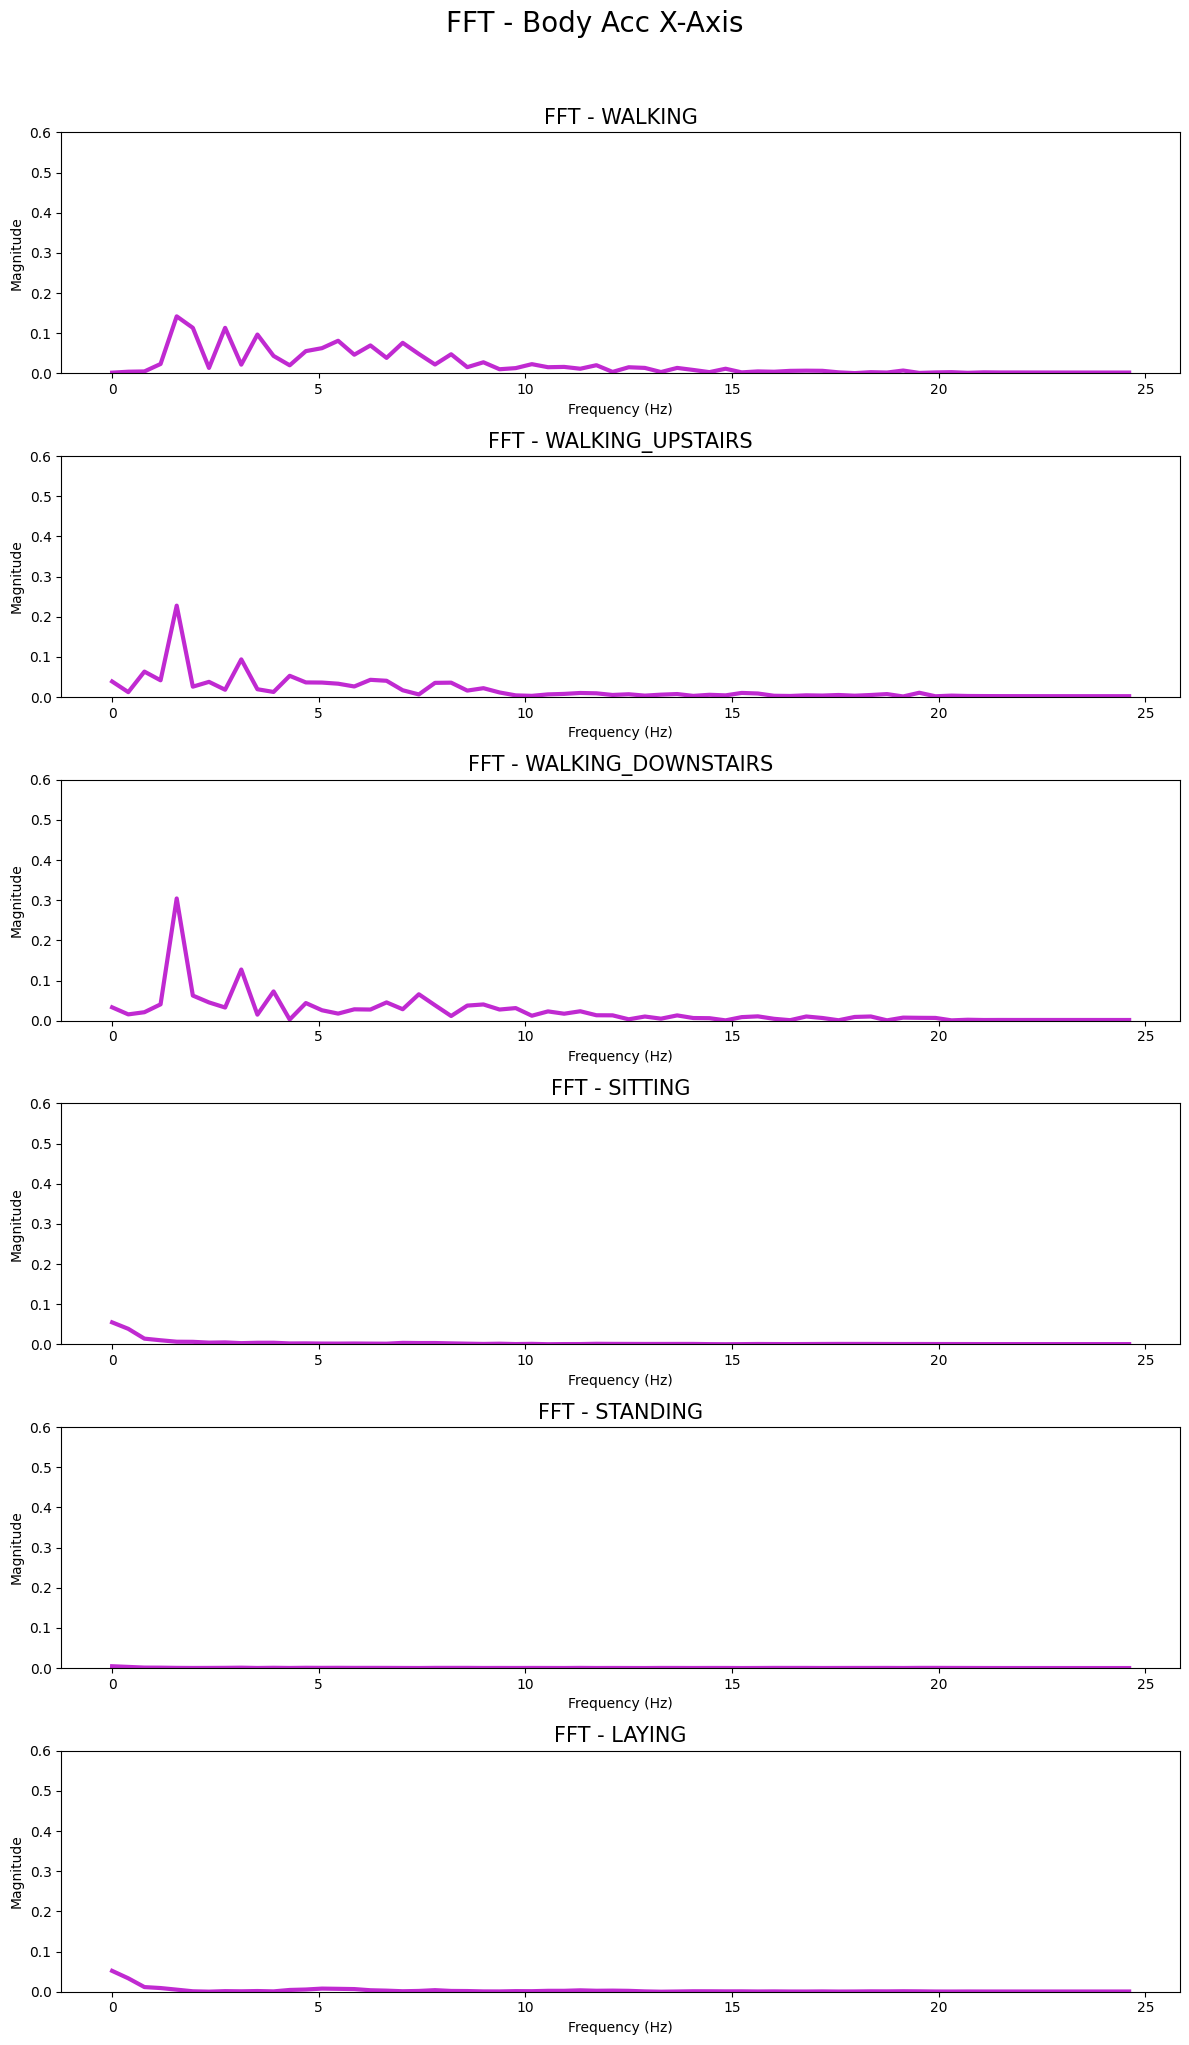

In [ ]:
'''
SITTING이나 LAYING 같은 정적 활동은 주파수가 0에 가깝게 매우 낮다. 
WALKING은 1~2Hz 사이의 매우 규칙적인 주파수 성분(발걸음)을 가진다.
WALKING_UPSTAIRS는 WALKING보다 좀 더 빠르거나 불규칙한 주파수 성분이 섞일 수 있다.

-> FFT(고속 푸리에 변환)를 통해 "신호가 얼마나 빠른가/주기적인가"를 분석하면 활동을 구분하는 강력한 단서를 
   얻을 수 있다. 
'''

# 샘플링 속도 (UCI-HAR는 50Hz로 수집됨)
SAMPLING_RATE = 50
# 윈도우 크기 (128)
N = 128 

fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(12, 20))
fig.suptitle('FFT - Body Acc X-Axis', fontsize=20, y=1.02)

# X축 (주파수)
# 50Hz, 128개 샘플 -> 0~25Hz까지 분석 가능 (Nyquist)
xf = fftfreq(N, 1 / SAMPLING_RATE)[:N//2] # N//2 까지만 사용

for i, activity_name in enumerate(activity_names):
    sample_idx = activity_indices[activity_name]
    
    # Body Acc-X (채널 0) 신호
    signal = train_ds.X[sample_idx, :, 0]
    
    # FFT 수행
    yf = fft(signal)
    # Magnitude 계산 (양수 부분만)
    magnitude = 2.0/N * np.abs(yf[0:N//2])

    # 시각화
    ax = axes[i]
    ax.plot(xf, magnitude, '#c02ad1', linewidth=3)
    ax.set_title(f'FFT - {activity_name}', fontsize=15)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Magnitude')
    ax.set_ylim(0, 0.6) # Y축 스케일 고정 (비교를 위해)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

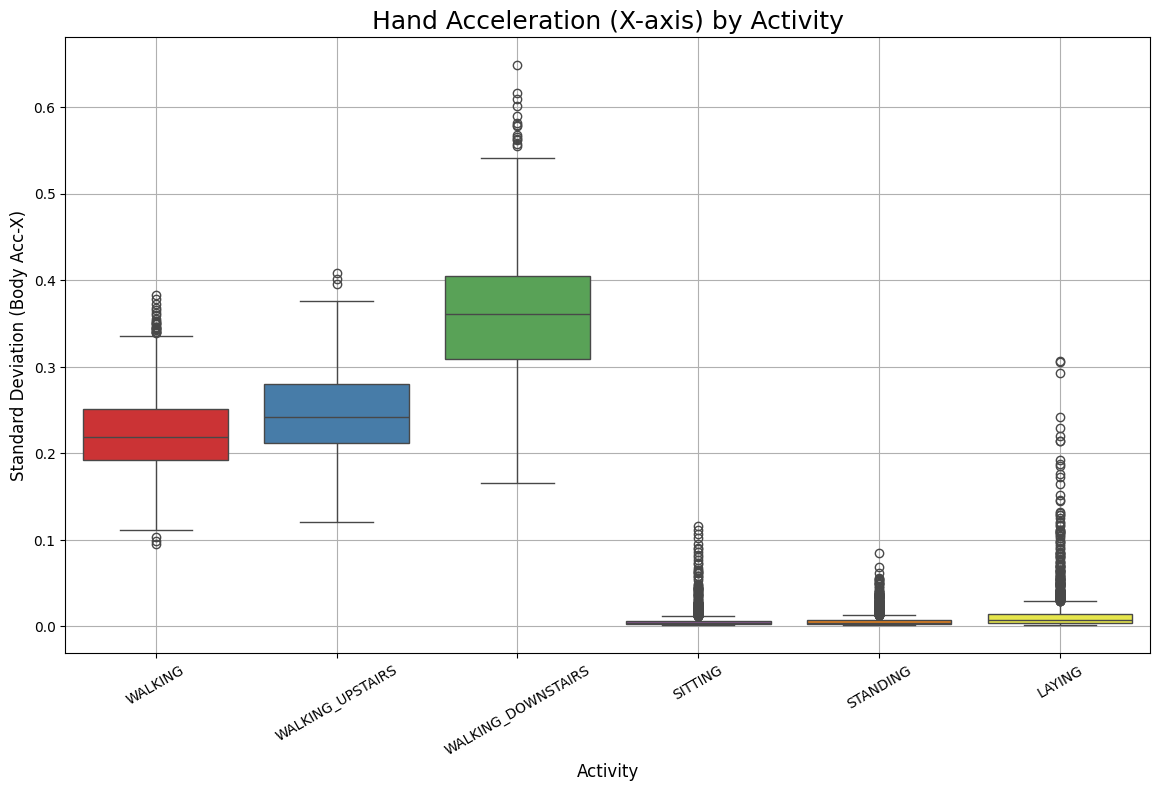

In [ ]:
# 1. Train/Test 데이터셋의 모든 X 데이터를 하나로 합칩니다.
all_X = np.concatenate([train_ds.X, test_ds.X], axis=0)
# (이전 단계의 통합 DataFrame 'df'를 그대로 사용)

# 2. 통계 피처 계산 (예: Body Acc X축의 표준편차)
# all_X shape: (10299, 128, 9)
# 채널 0 (Body Acc-X)의 128개 타임스텝에 대한 표준편차 계산
feature_std_acc_x = np.std(all_X[:, :, 0], axis=1)

# 3. 이 피처를 기존 'df'에 추가
df['feat_std_acc_x'] = feature_std_acc_x

# 4. Boxplot 또는 Violin Plot으로 시각화
plt.figure(figsize=(14, 8))
sns.boxplot(
    x='activity_name', 
    y='feat_std_acc_x', 
    data=df,
    order=activity_names, # 활동 순서 고정
    palette='Set1'
)
plt.title('Hand Acceleration (X-axis) by Activity', fontsize=18)
plt.xlabel('Activity', fontsize=12)
plt.ylabel('Standard Deviation (Body Acc-X)', fontsize=12)
plt.xticks(rotation=30)
plt.grid(True)
plt.show()

In [ ]:
# 9개 채널 이름 (UCIHARDataset 클래스 로드 순서 기준)
channel_names = [
    'body_acc_x', 'body_acc_y', 'body_acc_z',
    'body_gyro_x', 'body_gyro_y', 'body_gyro_z',
    'total_acc_x', 'total_acc_y', 'total_acc_z'
]

# 계산된 피처를 담을 새로운 DataFrame
df_features = pd.DataFrame()

print("Calculating statistical features...")
for i, name in enumerate(channel_names):
    # 128개 타임스텝(axis=1)에 대해 평균(mean)과 표준편차(std) 계산
    df_features[f'{name}_mean'] = np.mean(all_X[:, :, i], axis=1)
    df_features[f'{name}_std'] = np.std(all_X[:, :, i], axis=1)

print(f"생성된 피처 DataFrame Shape: {df_features.shape}") # (10299, 18)
display(df_features.head())

Calculating statistical features...
생성된 피처 DataFrame Shape: (10299, 18)


,body_acc_x_mean,body_acc_x_std,body_acc_y_mean,body_acc_y_std,body_acc_z_mean,body_acc_z_std,body_gyro_x_mean,body_gyro_x_std,body_gyro_y_mean,body_gyro_y_std,body_gyro_z_mean,body_gyro_z_std,total_acc_x_mean,total_acc_x_std,total_acc_y_mean,total_acc_y_std,total_acc_z_mean,total_acc_z_std
0,0.002269,0.002941,-0.001655,0.004601,-0.008126,0.018504,0.022250,0.014434,0.019403,0.019828,0.009468,0.005943,1.019305,0.001791,-0.124262,0.003270,0.099732,0.003970
1,0.000174,0.001981,0.000382,0.005930,-0.005025,0.010122,0.011926,0.016334,-0.004314,0.010356,0.006308,0.007431,1.019448,0.001932,-0.122936,0.004930,0.096939,0.004918
2,0.000428,0.002908,-0.001222,0.007310,-0.001703,0.006786,-0.004150,0.022256,-0.012640,0.006920,0.004335,0.008753,1.019927,0.002904,-0.124997,0.006460,0.092897,0.006145
3,0.000329,0.002678,-0.004753,0.004551,-0.004947,0.004684,-0.016228,0.009165,-0.007697,0.007793,-0.000352,0.008186,1.020349,0.002574,-0.130493,0.004029,0.087654,0.004945
4,-0.000195,0.002015,0.000298,0.004991,-0.002330,0.004719,-0.006483,0.014544,-0.000166,0.007815,-0.003957,0.008260,1.020255,0.001949,-0.130209,0.003876,0.084999,0.003637


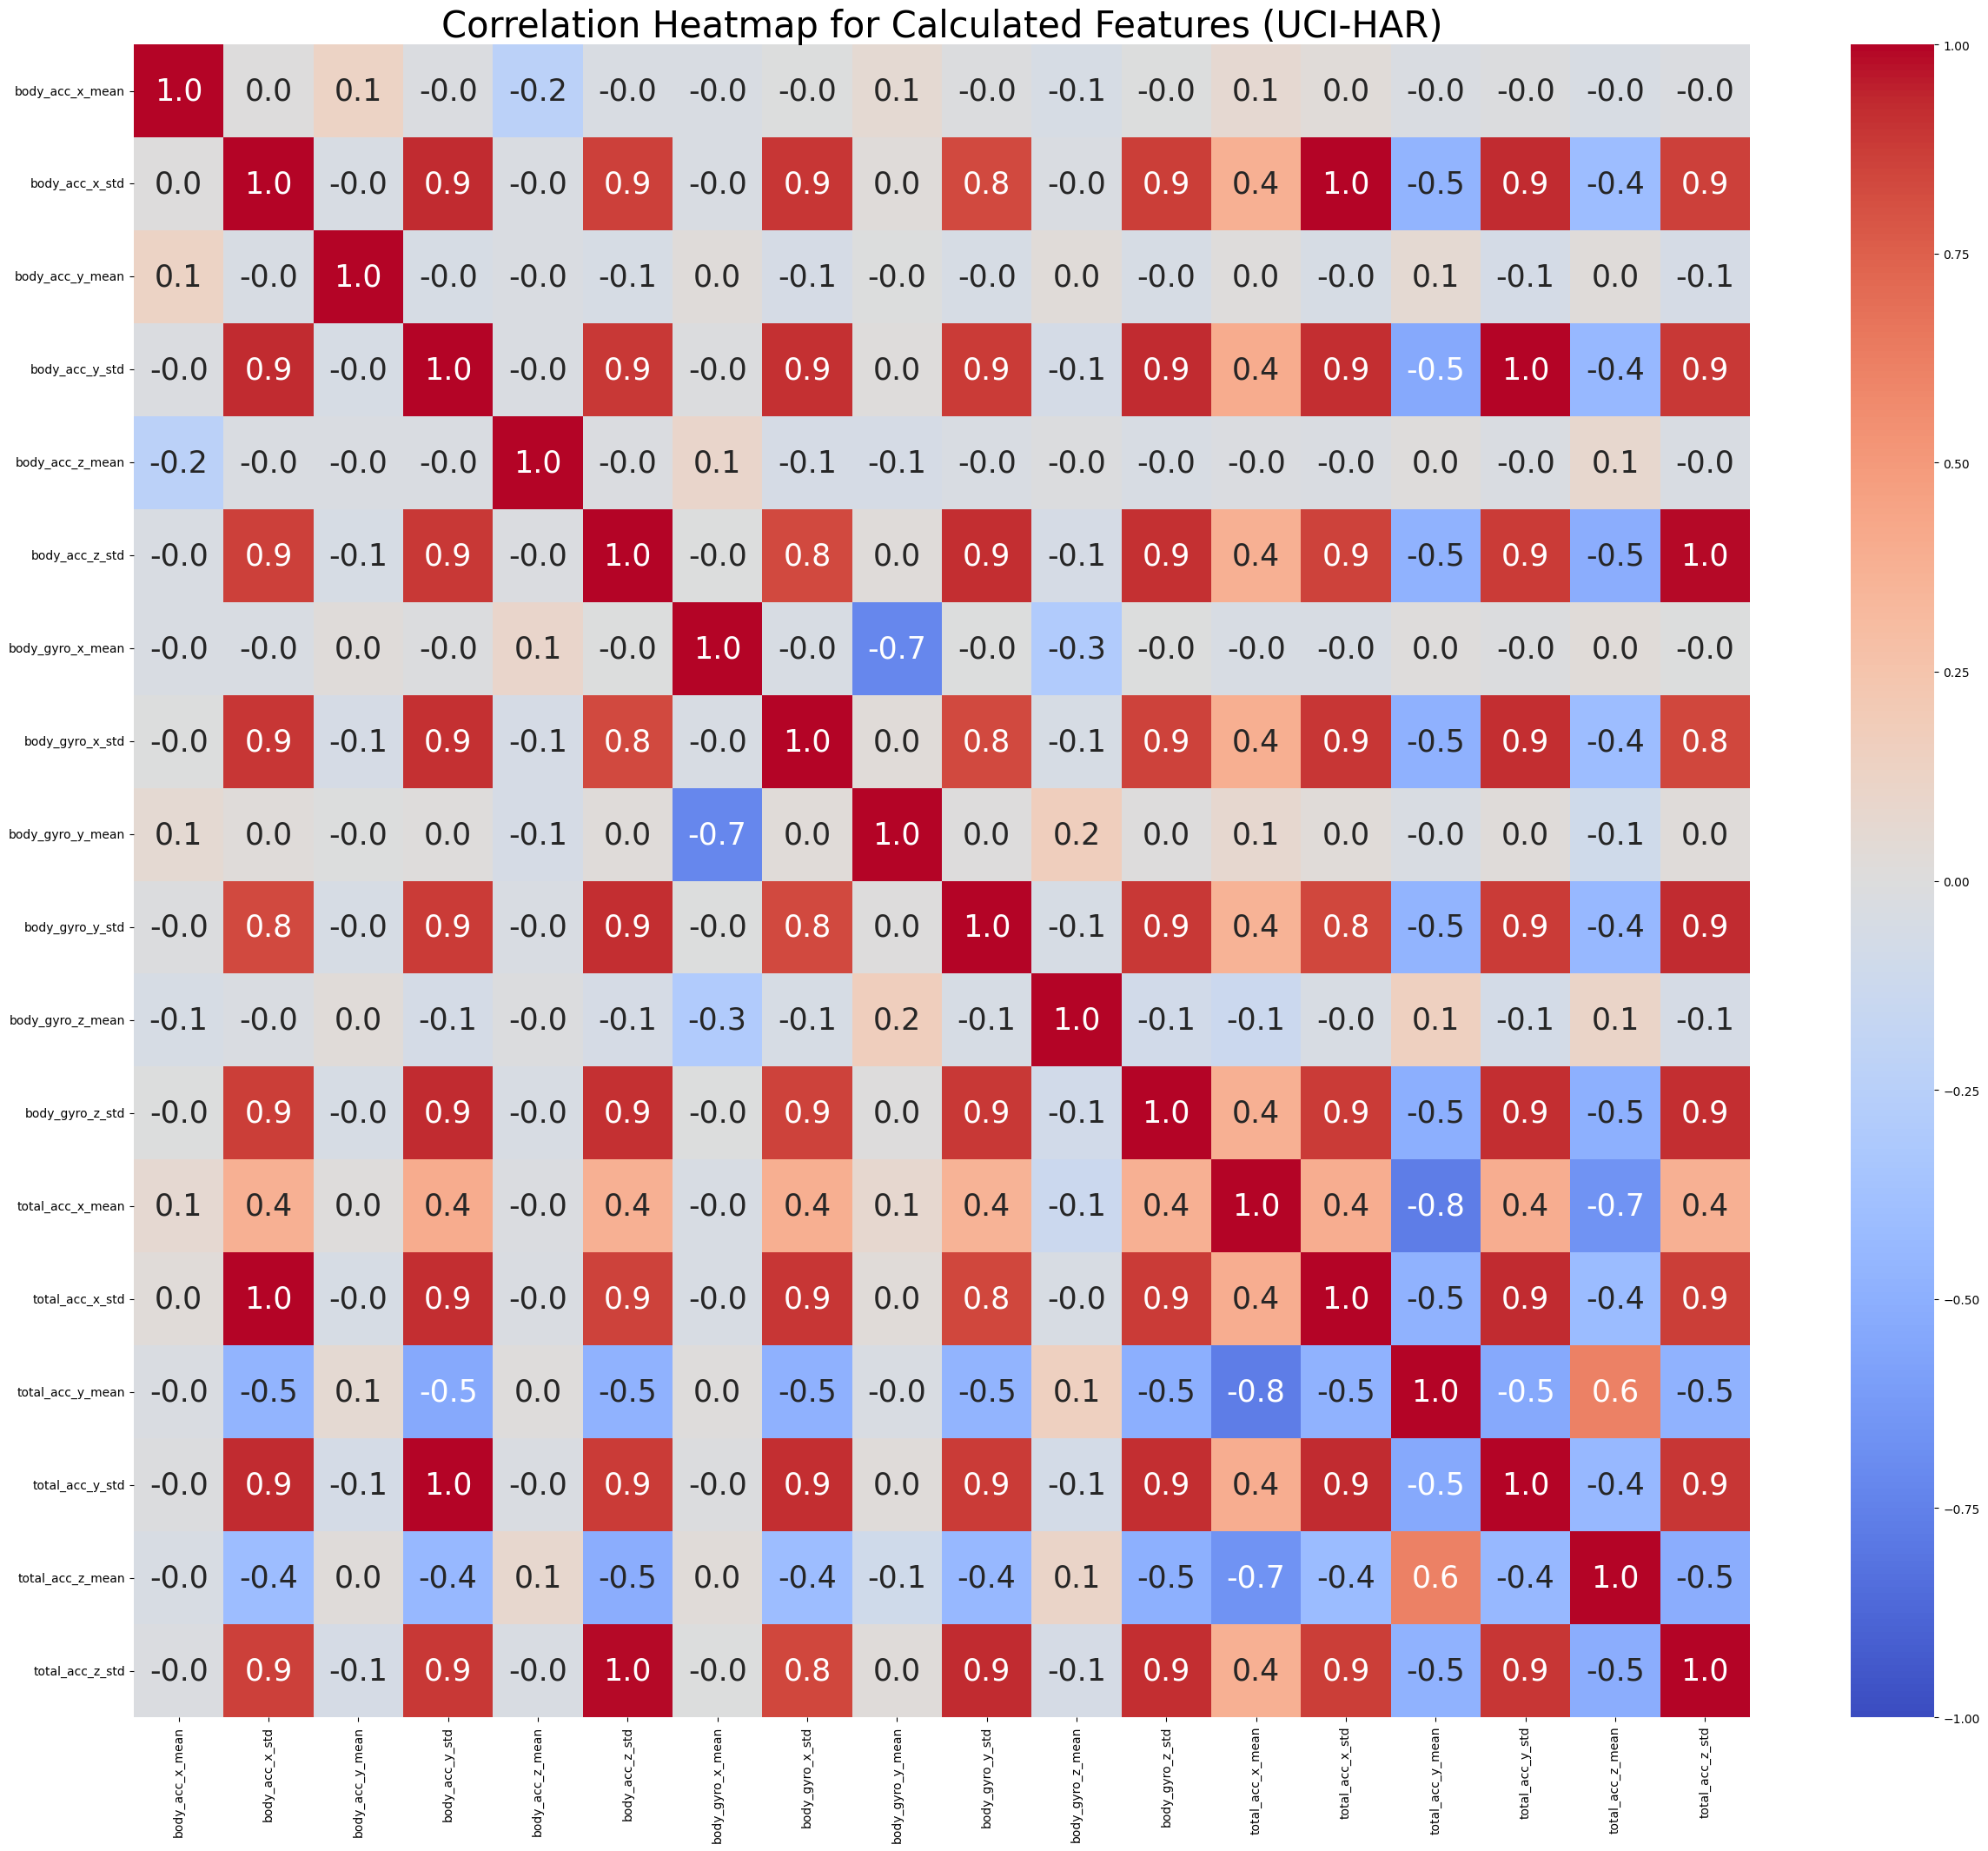

In [10]:
# 피처 DataFrame의 상관관계 계산
corr_matrix = df_features.corr()

# 18x18 매트릭스이므로 차트 크기를 키웁니다.
plt.figure(figsize=(30, 25))

sns.heatmap(
    corr_matrix, 
    annot=True, 
    annot_kws={"size": 25}, # 18x18이라 글씨 크기 조정
    fmt='.1f', 
    cmap='coolwarm', 
    vmin=-1, vmax=1 
)
plt.title('Correlation Heatmap for Calculated Features (UCI-HAR)', fontsize=30)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()